# Generative Adversarial Network

Reference: https://github.com/eriklindernoren/Keras-GAN/

## Setting

Mount Google Drive

In [3]:
from google.colab import drive

mount_folder = '/content/gdrive'
drive.mount(mount_folder)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Go into the working directory

In [0]:
import os

app_folder = mount_folder + '/My Drive/'
os.chdir(app_folder)

Input

In [0]:
from pathlib import Path

def get_banner_folder(prefixe = 'original'):
  banner_folder = 'data/'+prefixe+'_steam_banners/'
  Path(banner_folder).mkdir(exist_ok=True)  
  return banner_folder

def get_file_extension():
  return '.jpg'
  
def get_banner_file_name(app_id):
  return get_banner_folder() + str(app_id) + get_file_extension()

Banners which are a black background

In [0]:
def get_skipped_banners():
  skipped_app_ids = [396540]
  skipped_banners = [get_banner_folder() + str(app_id) + get_file_extension() for app_id in skipped_app_ids]
  return skipped_banners

## Aggregate 56x56 images once, for faster processing later on

Aggregate Steam banners into a NumPy structure

---



In [0]:
import glob
import numpy as np

from time import time

from keras.preprocessing.image import load_img

def get_matrix_file_name(img_rows=56, img_cols=56, channels=1):
  return 'data/banner_matrix_'+str(img_rows)+'x'+str(img_cols)+'x'+str(channels)+'.npy'


def prepare_data_matrix(img_rows=56, img_cols=56, channels=1, prefixe = 'original', reset_matrix=False):     
  all_image_names = glob.glob(get_banner_folder(prefixe) + '*' + get_file_extension())  
  
  # There is an issue with duplicates, e.g. 'ABC (1).jpg' but only when running on Google Drive:
  image_names = [img for img in all_image_names if ' (' not in img]
  
  num_samples = len(image_names)
    
  if reset_matrix:
    X_train = np.zeros((num_samples, img_rows, img_cols, channels))    
  else:
    try:
      X_train = np.load(get_matrix_file_name(img_rows, img_cols, channels))
    except FileNotFoundError:
      X_train = np.zeros((num_samples, img_rows, img_cols, channels))    
    
  has_changed = False
  start = time()
  
  for counter, image_name in enumerate(sorted(image_names)):    
    
    if np.any(X_train[counter,...]!=0) or (image_name in get_skipped_banners()):
      continue
    
    if (counter+1) % 100 == 0:
      print('Elapsed time: {:.2f} s'.format(time() - start))
      start = time()      
      print('Iteration {}/{}'.format(counter+1, num_samples))
      if has_changed:
        np.save(get_matrix_file_name(img_rows, img_cols, channels), X_train)
        has_changed = False        

    image = load_img(image_name, target_size=(img_rows, img_cols))    
    has_changed = True
    
    # Grayscale
    if channels==1:
      image = np.expand_dims(np.mean(image, axis=2), axis=2)

    X_train[counter, ...] = image    
  
  if has_changed:
    print('Saving.')
    np.save(get_matrix_file_name(img_rows, img_cols, channels), X_train)
  
  return X_train

Choose image size and the number of channels (color vs. grayscale image). Preferably, choose a rather high image size, e.g. 56x56, so that the NumPy structure has a decent size but is not too large, e.g. about 2 GB if images have 3 color channels.

If we need smaller images later on, we could load this dataset and downsample the stored images. The fact that we would not have to load the images from the disk would make the process fast enough.

In [0]:
default_img_rows=56
default_img_cols=56
default_channels=3

Aggregate images, resized to 56x56 pixels

In [0]:
X_train = prepare_data_matrix(img_rows=default_img_rows, img_cols=default_img_cols, channels=default_channels, prefixe='resized', reset_matrix=False)  

## Pre-processing

Choose image size and the number of channels (color vs. grayscale image)

In [0]:
img_rows=28
img_cols=28
channels=3

# Color images cannot be created from stored grayscale images
assert(channels <= default_channels)

Resize images stored in X_train

In [0]:
import cv2

input_file_name = get_matrix_file_name(default_img_rows, default_img_cols, default_channels)
output_file_name = get_matrix_file_name(img_rows, img_cols, channels)

if not Path(output_file_name).exists():

  X_train = np.load(input_file_name)

  num_samples = X_train.shape[0]

  X_train_resized = np.zeros((num_samples, img_rows, img_cols, channels))
  for index, image in enumerate(X_train):
    resized_image = cv2.resize(image, (img_rows, img_cols))

    if default_channels > 1:
      if channels > 1:
        pass
      else:
        resized_image = np.mean(resized_image, axis=2)
        resized_image = np.expand_dims(resized_image, axis=2)
    else:
      resized_image = np.expand_dims(resized_image, axis=2)

    X_train_resized[index, ...] = resized_image

  np.save(output_file_name, X_train_resized)

Load pre-computed aggregate of resized Steam banners

In [13]:
X_train = np.load(get_matrix_file_name(img_rows, img_cols, channels))

X_train.shape

(27974, 28, 28, 3)

Display Steam banners of real games

In [0]:
import matplotlib.pyplot as plt
import cv2

def plot_grid_of_banners(banner_matrix, r=5, c=3, upsample_to_original_size=True):
  
  if upsample_to_original_size:
    original_shape = [215, 460]
    num_banners_to_print = r*c
    
    gen_imgs_large = np.zeros((num_banners_to_print, original_shape[0], original_shape[1], banner_matrix.shape[-1]))
    for i in range(num_banners_to_print):
      gen_imgs_large[i, ...] = cv2.resize(banner_matrix[i, ...], (original_shape[1], original_shape[0]))
      
    banner_matrix = gen_imgs_large.copy()
  
  num_channels = banner_matrix.shape[-1]

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          if num_channels > 1:
            image = np.array(banner_matrix[cnt, ...])
          else:
            image = 255 - np.array(banner_matrix[cnt, :, :, 0])
          # Reference: https://stackoverflow.com/a/51255361
          try:
            axs[i,j].imshow(image.astype(np.uint8))
            axs[i,j].axis('off')
          except TypeError:
            plt.imshow(image.astype(np.uint8))
            plt.axis('off')
          cnt += 1
  plt.show()          
  
  return

def plot_samples_generated_by_model(model, r=5, c=3, upsample_to_original_size=True): 
  
  noise = np.random.normal(0, 1, (r * c, model.latent_dim))
  gen_imgs = model.generator.predict(noise)
 
  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  # Rescale images 0 - 255
  gen_imgs = 255 * gen_imgs
    
  plot_grid_of_banners(gen_imgs, r, c, upsample_to_original_size)
  
  return

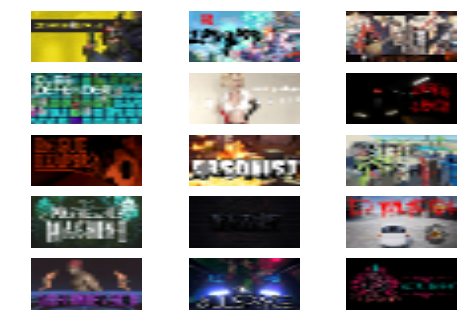

In [156]:
plot_grid_of_banners(X_train)

## Train GAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class GAN():
    # CODE CHANGED BELOW
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_gan/'
        Path(self.image_folder).mkdir(exist_ok=True)             
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
              # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])                    
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

In [0]:
gan = GAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1204736   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,336,321
Trainable params: 1,336,321
Non-trainable para

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

gan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 5464 with mini-batch size = 128 for 25 epochs over 27974 samples
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.712042, acc.: 33.98%] [G loss: 0.515880]
100 [D loss: 0.754313, acc.: 60.16%] [G loss: 1.276081]
200 [D loss: 0.798369, acc.: 52.73%] [G loss: 1.111127]
300 [D loss: 0.731146, acc.: 58.59%] [G loss: 1.023637]
400 [D loss: 0.788774, acc.: 44.92%] [G loss: 0.894888]
500 [D loss: 0.781819, acc.: 36.33%] [G loss: 0.822662]
600 [D loss: 0.790069, acc.: 24.22%] [G loss: 0.820587]
700 [D loss: 0.712545, acc.: 50.78%] [G loss: 0.805980]
800 [D loss: 0.726856, acc.: 48.44%] [G loss: 0.784095]
900 [D loss: 0.729395, acc.: 47.27%] [G loss: 0.805397]
1000 [D loss: 0.727005, acc.: 46.48%] [G loss: 0.755089]
1100 [D loss: 0.731260, acc.: 34.77%] [G loss: 0.778040]
1200 [D loss: 0.723763, acc.: 42.58%] [G loss: 0.740025]
1300 [D loss: 0.722160, acc.: 42.58%] [G loss: 0.754269]
1400 [D loss: 0.738831, acc.: 29.30%] [G loss: 0.739615]
1500 [D loss: 0.722224, acc.: 47.66%] [G loss: 0.730419]
1600 [D loss: 0.701361, acc.: 47.66%] [G loss: 0.743172]
1700 [D loss: 0.715662, acc.: 39.45%] [G lo

Display sampled banners

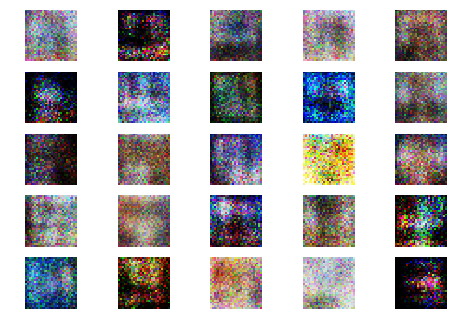

In [0]:
plot_samples_generated_by_model(gan)

## Train WGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class WGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_wgan/'
        Path(self.image_folder).mkdir(exist_ok=True)                
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Flatten())
          model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Reshape(self.img_shape))      

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:        
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)
                
                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [0]:
wgan = WGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        448       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 32)          128       
___________________________

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

wgan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 5464 with mini-batch size = 128 for 25 epochs over 27974 samples


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999926] [G loss: 1.000145]
100 [D loss: 0.999978] [G loss: 1.000077]
200 [D loss: 0.999970] [G loss: 1.000068]
300 [D loss: 0.999970] [G loss: 1.000067]
400 [D loss: 0.999972] [G loss: 1.000066]
500 [D loss: 0.999971] [G loss: 1.000070]
600 [D loss: 0.999974] [G loss: 1.000061]
700 [D loss: 0.999974] [G loss: 1.000051]
800 [D loss: 0.999974] [G loss: 1.000060]
900 [D loss: 0.999975] [G loss: 1.000064]
1000 [D loss: 0.999974] [G loss: 1.000064]
1100 [D loss: 0.999974] [G loss: 1.000061]
1200 [D loss: 0.999973] [G loss: 1.000059]
1300 [D loss: 0.999976] [G loss: 1.000057]
1400 [D loss: 0.999975] [G loss: 1.000058]
1500 [D loss: 0.999976] [G loss: 1.000049]
1600 [D loss: 0.999978] [G loss: 1.000048]
1700 [D loss: 0.999970] [G loss: 1.000054]
1800 [D loss: 0.999977] [G loss: 1.000061]
1900 [D loss: 0.999973] [G loss: 1.000052]
2000 [D loss: 0.999979] [G loss: 1.000053]
2100 [D loss: 0.999989] [G loss: 1.000024]
2200 [D loss: 0.999971] [G loss: 1.000063]
2300 [D loss: 0.999974]

Display sampled banners

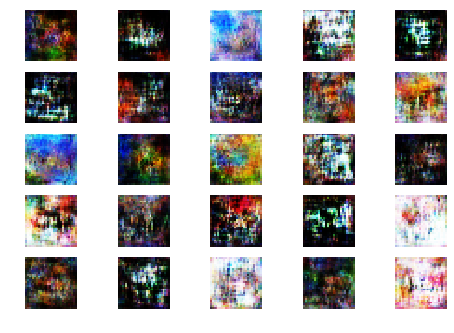

In [0]:
plot_samples_generated_by_model(wgan)

## Train DCGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class DCGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_dcgan/'
        Path(self.image_folder).mkdir(exist_ok=True)                
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Flatten())
          model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [120]:
dcgan = DCGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

Training parameters

In [0]:
num_epochs = 250
batch_size = 64 # 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

dcgan.train(epochs=num_iter, batch_size=batch_size, save_interval=1000)

Display sampled banners

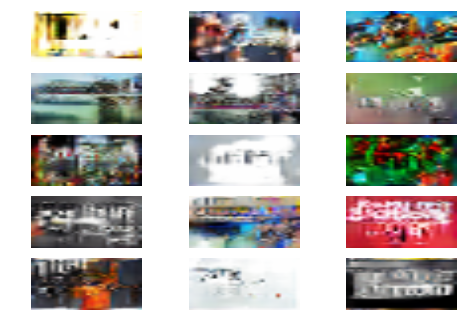

In [136]:
plot_samples_generated_by_model(dcgan)

## Train BGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/bgan/bgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class BGAN():
    """Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/"""
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_bgan/'
        Path(self.image_folder).mkdir(exist_ok=True)            

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.boundary_loss, optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def boundary_loss(self, y_true, y_pred):
        """
        Boundary seeking loss.
        Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/
        """
        return 0.5 * K.mean((K.log(y_pred) - K.log(1 - y_pred))**2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)      

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:            
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

In [0]:
bgan = BGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1204736   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,336,321
Trainable params: 1,336,321
Non-trainable para

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

bgan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 54637 with mini-batch size = 128 for 250 epochs over 27974 samples
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.703949, acc.: 39.84%] [G loss: 0.267077]
100 [D loss: 0.594935, acc.: 71.48%] [G loss: 0.808248]
200 [D loss: 0.782253, acc.: 50.00%] [G loss: 0.407446]
300 [D loss: 0.677730, acc.: 59.77%] [G loss: 0.328295]
400 [D loss: 0.690234, acc.: 58.98%] [G loss: 0.255372]
500 [D loss: 0.705408, acc.: 55.86%] [G loss: 0.200642]
600 [D loss: 0.737775, acc.: 53.52%] [G loss: 0.187303]
700 [D loss: 0.671430, acc.: 61.72%] [G loss: 0.177486]
800 [D loss: 0.656066, acc.: 60.55%] [G loss: 0.183659]
900 [D loss: 0.685206, acc.: 62.11%] [G loss: 0.109340]
1000 [D loss: 0.682771, acc.: 63.28%] [G loss: 0.188784]
1100 [D loss: 0.674690, acc.: 57.42%] [G loss: 0.104566]
1200 [D loss: 0.663444, acc.: 64.84%] [G loss: 0.084090]
1300 [D loss: 0.696200, acc.: 60.55%] [G loss: 0.077321]
1400 [D loss: 0.647896, acc.: 62.50%] [G loss: 0.067299]
1500 [D loss: 0.687983, acc.: 58.59%] [G loss: 0.070891]
1600 [D loss: 0.675661, acc.: 58.98%] [G loss: 0.056259]
1700 [D loss: 0.700749, acc.: 53.91%] [G lo

Display sampled banners

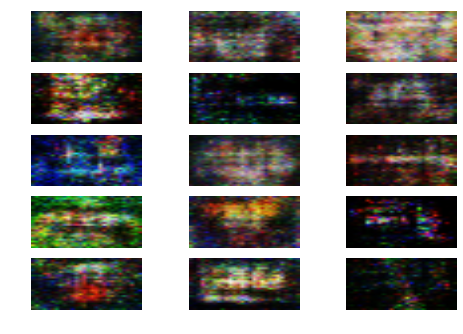

In [0]:
plot_samples_generated_by_model(bgan)

## Train BIGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/bigan/bigan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class BIGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
        
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_bigan/'
        Path(self.image_folder).mkdir(exist_ok=True)           

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the encoder
        self.encoder = self.build_encoder()

        # The part of the bigan that trains the discriminator and encoder
        self.discriminator.trainable = False

        # Generate image from sampled noise
        z = Input(shape=(self.latent_dim, ))
        img_ = self.generator(z)

        # Encode image
        img = Input(shape=self.img_shape)
        z_ = self.encoder(img)

        # Latent -> img is fake, and img -> latent is valid
        fake = self.discriminator([z, img_])
        valid = self.discriminator([z_, img])

        # Set up and compile the combined model
        # Trains generator to fool the discriminator
        self.bigan_generator = Model([z, img], [fake, valid])
        self.bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)


    def build_encoder(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.latent_dim))

        model.summary()

        img = Input(shape=self.img_shape)
        z = model(img)

        return Model(img, z)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        z = Input(shape=(self.latent_dim,))
        gen_img = model(z)

        return Model(z, gen_img)

    def build_discriminator(self):

        z = Input(shape=(self.latent_dim, ))
        img = Input(shape=self.img_shape)
        d_in = concatenate([z, Flatten()(img)])

        model = Dense(1024)(d_in)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        validity = Dense(1, activation="sigmoid")(model)

        return Model([z, img], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)         
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):


            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Sample noise and generate img
            z = np.random.normal(size=(batch_size, self.latent_dim))
            imgs_ = self.generator.predict(z)

            # Select a random batch of images and encode
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            z_ = self.encoder.predict(imgs)

            # Train the discriminator (img -> z is valid, z -> img is fake)
            d_loss_real = self.discriminator.train_on_batch([z_, imgs], valid)
            d_loss_fake = self.discriminator.train_on_batch([z, imgs_], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (z -> img is valid and img -> z is is invalid)
            g_loss = self.bigan_generator.train_on_batch([z, imgs], [valid, fake])

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:            
              print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_interval(epoch)

    def sample_interval(self, epoch):
        r, c = 5, 5
        z = np.random.normal(size=(25, self.latent_dim))
        gen_imgs = self.generator.predict(z)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

In [0]:
bigan = BIGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

bigan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Display sampled banners

In [0]:
plot_samples_generated_by_model(bigan)

## Train LSGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/lsgan/lsgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class LSGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
		
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_lsgan/'
        Path(self.image_folder).mkdir(exist_ok=True)   		

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(z, valid)
        # (!!!) Optimize w.r.t. MSE loss instead of crossentropy
        self.combined.compile(loss='mse', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        # (!!!) No softmax
        model.add(Dense(1))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)   

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:			
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [39]:
lsgan = LSGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1204736   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,336,321
Trainable params: 1,336,321
Non-trainable params: 0
_________________________________________________________________


Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [41]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

lsgan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 54637 with mini-batch size = 128 for 250 epochs over 27974 samples


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.463258, acc.: 65.62%] [G loss: 0.397073]
100 [D loss: 0.672596, acc.: 49.22%] [G loss: 0.976585]
200 [D loss: 0.615074, acc.: 45.70%] [G loss: 0.665353]
300 [D loss: 0.460726, acc.: 48.05%] [G loss: 0.630775]
400 [D loss: 0.480342, acc.: 31.25%] [G loss: 0.607307]
500 [D loss: 0.379214, acc.: 36.72%] [G loss: 0.527131]
600 [D loss: 0.350664, acc.: 48.05%] [G loss: 0.494364]
700 [D loss: 0.382416, acc.: 40.23%] [G loss: 0.686906]
800 [D loss: 0.339291, acc.: 53.91%] [G loss: 0.486251]
900 [D loss: 0.325649, acc.: 51.95%] [G loss: 0.468634]
1000 [D loss: 0.387809, acc.: 38.28%] [G loss: 0.563117]
1100 [D loss: 0.322710, acc.: 46.09%] [G loss: 0.543520]
1200 [D loss: 0.320821, acc.: 44.92%] [G loss: 0.569587]
1300 [D loss: 0.344541, acc.: 37.50%] [G loss: 0.450440]
1400 [D loss: 0.313549, acc.: 46.88%] [G loss: 0.464364]
1500 [D loss: 0.317993, acc.: 45.70%] [G loss: 0.438748]
1600 [D loss: 0.303320, acc.: 41.41%] [G loss: 0.440598]
1700 [D loss: 0.282918, acc.: 43.75%] [G lo

Display sampled banners

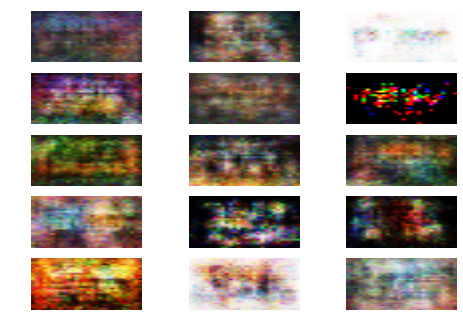

In [42]:
plot_samples_generated_by_model(lsgan)

## Train COGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/28aac9884eb458dddda3b578e53fc378fd58ab39/cogan/cogan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

import scipy

In [0]:
class COGAN():
    """Reference: https://wiseodd.github.io/techblog/2017/02/18/coupled_gan/"""
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_cogan/'
        Path(self.image_folder).mkdir(exist_ok=True)   

        # Build and compile the discriminator
        self.d1, self.d2 = self.build_discriminators()
        self.d1.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d2.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.g1, self.g2 = self.build_generators()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img1 = self.g1(z)
        img2 = self.g2(z)

        # For the combined model we will only train the generators
        self.d1.trainable = False
        self.d2.trainable = False

        # The valid takes generated images as input and determines validity
        valid1 = self.d1(img1)
        valid2 = self.d2(img2)

        # The combined model  (stacked generators and discriminators)
        # Trains generators to fool discriminators
        self.combined = Model(z, [valid1, valid2])
        self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
                                    optimizer=optimizer)

    def build_generators(self):

        # Shared weights between generators
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        noise = Input(shape=(self.latent_dim,))
        feature_repr = model(noise)

        # Generator 1
        g1 = Dense(1024)(feature_repr)
        g1 = LeakyReLU(alpha=0.2)(g1)
        g1 = BatchNormalization(momentum=0.8)(g1)
        g1 = Dense(np.prod(self.img_shape), activation='tanh')(g1)
        img1 = Reshape(self.img_shape)(g1)

        # Generator 2
        g2 = Dense(1024)(feature_repr)
        g2 = LeakyReLU(alpha=0.2)(g2)
        g2 = BatchNormalization(momentum=0.8)(g2)
        g2 = Dense(np.prod(self.img_shape), activation='tanh')(g2)
        img2 = Reshape(self.img_shape)(g2)

        model.summary()

        return Model(noise, img1), Model(noise, img2)

    def build_discriminators(self):

        img1 = Input(shape=self.img_shape)
        img2 = Input(shape=self.img_shape)

        # Shared discriminator layers
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))

        img1_embedding = model(img1)
        img2_embedding = model(img2)

        # Discriminator 1
        validity1 = Dense(1, activation='sigmoid')(img1_embedding)
        # Discriminator 2
        validity2 = Dense(1, activation='sigmoid')(img2_embedding)

        return Model(img1, validity1), Model(img2, validity2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)   

        # Images in domain A and B (rotated)
        X1 = X_train[:int(X_train.shape[0]/2)]
        X2 = X_train[int(X_train.shape[0]/2):]
        X2 = scipy.ndimage.interpolation.rotate(X2, 90, axes=(1, 2))

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminators
            # ----------------------

            # Select a random batch of images
            idx = np.random.randint(0, X1.shape[0], batch_size)
            imgs1 = X1[idx]
            imgs2 = X2[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a batch of new images
            gen_imgs1 = self.g1.predict(noise)
            gen_imgs2 = self.g2.predict(noise)

            # Train the discriminators
            d1_loss_real = self.d1.train_on_batch(imgs1, valid)
            d2_loss_real = self.d2.train_on_batch(imgs2, valid)
            d1_loss_fake = self.d1.train_on_batch(gen_imgs1, fake)
            d2_loss_fake = self.d2.train_on_batch(gen_imgs2, fake)
            d1_loss = 0.5 * np.add(d1_loss_real, d1_loss_fake)
            d2_loss = 0.5 * np.add(d2_loss_real, d2_loss_fake)


            # ------------------
            #  Train Generators
            # ------------------

            g_loss = self.combined.train_on_batch(noise, [valid, valid])

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:			
              print ("%d [D1 loss: %f, acc.: %.2f%%] [D2 loss: %f, acc.: %.2f%%] [G loss: %f]" \
                % (epoch, d1_loss[0], 100*d1_loss[1], d2_loss[0], 100*d2_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * int(c/2), 100))
        gen_imgs1 = self.g1.predict(noise)
        gen_imgs2 = self.g2.predict(noise)

        gen_imgs = np.concatenate([gen_imgs1, gen_imgs2])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [50]:
cogan = COGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_23 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
Total params: 160,512
Trainable params: 158,976
Non-trainable params: 1,536
_________________________________________________________________


Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [47]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

cogan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 54637 with mini-batch size = 128 for 250 epochs over 27974 samples


NameError: ignored

Display sampled banners

In [0]:
plot_samples_generated_by_model(cogan)

## Train WGAN-GP

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py

Import Python modules

In [0]:
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""       
    
    def _merge_function(self, inputs):
      
        # HARD-CODED VALUES BELOW (manually change according to the arguments chosen at runtime)
        self.batch_size = 128
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 3
      
        alpha = K.random_uniform((batch_size, img_rows, img_cols, channels))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_wgangp/'
        Path(self.image_folder).mkdir(exist_ok=True)   

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)   

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

In [115]:
wgangp = WGANGP(img_rows=img_rows, img_cols=img_cols, channels=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_49 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_22 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 28, 28, 128)       0         
__________

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [117]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

wgangp.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 54637 with mini-batch size = 128 for 250 epochs over 27974 samples


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 29.779478] [G loss: 0.028464]
100 [D loss: -0.337932] [G loss: 1.962771]


KeyboardInterrupt: ignored

Display sampled banners

In [0]:
plot_samples_generated_by_model(wgangp)

## Train Adversarial Autoencoder

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/aae/aae.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class AdversarialAutoencoder():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10

        optimizer = Adam(0.0002, 0.5)
		
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_aae/'
        Path(self.image_folder).mkdir(exist_ok=True)   		

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr = self.encoder(img)
        reconstructed_img = self.decoder(encoded_repr)

        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator determines validity of the encoding
        validity = self.discriminator(encoded_repr)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)


    def build_encoder(self):
        # Encoder

        img = Input(shape=self.img_shape)

        h = Flatten()(img)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        mu = Dense(self.latent_dim)(h)
        log_var = Dense(self.latent_dim)(h)
        latent_repr = merge([mu, log_var],
                mode=lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2),
                output_shape=lambda p: p[0])

        return Model(img, latent_repr)

    def build_decoder(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        z = Input(shape=(self.latent_dim,))
        img = model(z)

        return Model(z, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation="sigmoid"))
        model.summary()

        encoded_repr = Input(shape=(self.latent_dim, ))
        validity = model(encoded_repr)

        return Model(encoded_repr, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)   

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            latent_fake = self.encoder.predict(imgs)
            latent_real = np.random.normal(size=(batch_size, self.latent_dim))

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

            # Plot the progress
			      # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5

        z = np.random.normal(size=(r*c, self.latent_dim))
        gen_imgs = self.decoder.predict(z)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "aae_generator")
        save(self.discriminator, "aae_discriminator")

In [0]:
aae = AdversarialAutoencoder(img_rows=img_rows, img_cols=img_cols, channels=channels)

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

aae.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Display sampled banners

In [0]:
plot_samples_generated_by_model(aae)

## InfoGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class INFOGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.num_classes = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 72

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', self.mutual_info_loss]

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_infogan/'
        Path(self.image_folder).mkdir(exist_ok=True)   		        
        
        # Build and the discriminator and recognition network
        self.discriminator, self.auxilliary = self.build_disk_and_q_net()

        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the recognition network Q
        self.auxilliary.compile(loss=[self.mutual_info_loss],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        gen_input = Input(shape=(self.latent_dim,))
        img = self.generator(gen_input)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        valid = self.discriminator(img)
        # The recognition network produces the label
        target_label = self.auxilliary(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(gen_input, [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        gen_input = Input(shape=(self.latent_dim,))
        img = model(gen_input)

        model.summary()

        return Model(gen_input, img)


    def build_disk_and_q_net(self):

        img = Input(shape=self.img_shape)

        # Shared layers between discriminator and recognition network
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())

        img_embedding = model(img)

        # Discriminator
        validity = Dense(1, activation='sigmoid')(img_embedding)

        # Recognition
        q_net = Dense(128, activation='relu')(img_embedding)
        label = Dense(self.num_classes, activation='softmax')(q_net)

        # Return discriminator and recognition network
        return Model(img, validity), Model(img, label)


    def mutual_info_loss(self, c, c_given_x):
        """The mutual information metric we aim to minimize"""
        eps = 1e-8
        conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
        entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

        return conditional_entropy + entropy

    def sample_generator_input(self, batch_size):
        # Generator inputs
        sampled_noise = np.random.normal(0, 1, (batch_size, 62))
        sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
        sampled_labels = to_categorical(sampled_labels, num_classes=self.num_classes)

        return sampled_noise, sampled_labels

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)  

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and categorical labels
            sampled_noise, sampled_labels = self.sample_generator_input(batch_size)
            gen_input = np.concatenate((sampled_noise, sampled_labels), axis=1)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(gen_input)

            # Train on real and generated data
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            # Avg. loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator and Q-network
            # ---------------------

            g_loss = self.combined.train_on_batch(gen_input, [valid, sampled_labels])

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:            
                print ("%d [D loss: %.2f, acc.: %.2f%%] [Q loss: %.2f] [G loss: %.2f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 10, 10

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            sampled_noise, _ = self.sample_generator_input(c)
            label = to_categorical(np.full(fill_value=i, shape=(r,1)), num_classes=self.num_classes)
            gen_input = np.concatenate((sampled_noise, label), axis=1)
            gen_imgs = self.generator.predict(gen_input)
            gen_imgs = 0.5 * gen_imgs + 0.5
            cnt = 0
            for j in range(r):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")


In [57]:
infogan = INFOGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 6272)              457856    
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 128)       512       
__________

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

infogan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Display sampled banners

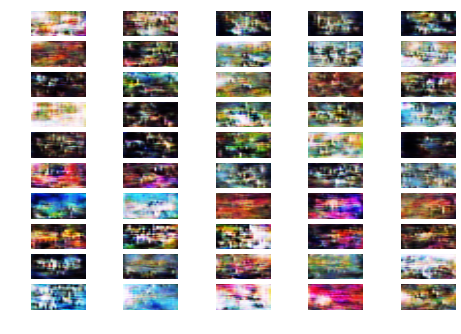

In [95]:
r = infogan.num_classes
c = 5

all_gen_imgs = np.zeros((r*c, img_rows, img_cols, channels))
total_cnt = 0

for i in range(r):
    sampled_noise, _ = infogan.sample_generator_input(c)
    label = to_categorical(np.full(fill_value=i, shape=(c, 1)), num_classes=infogan.num_classes)
    gen_input = np.concatenate((sampled_noise, label), axis=1)
    gen_imgs = infogan.generator.predict(gen_input)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Rescale images 0 - 255
    gen_imgs = 255 * gen_imgs    
    
    cnt = 0
    
    for j in range(c):
      
      all_gen_imgs[total_cnt, ...] = gen_imgs[cnt, ...]
      total_cnt += 1          
      
      cnt += 1 

plot_grid_of_banners(all_gen_imgs, r, c)

## Save the models to disk

#### DCGAN model

Save the DCGAN model

In [0]:
dcgan.generator.save_weights('dcgan_generator.hd5')
dcgan.discriminator.save_weights('dcgan_discriminator.hd5')
dcgan.combined.save_weights('dcgan_combined.hd5')

Save the DCGAN model

In [135]:
loaded_dcgan = DCGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)
loaded_dcgan.generator.load_weights('dcgan_generator.hd5')
loaded_dcgan.discriminator.load_weights('dcgan_discriminator.hd5')
loaded_dcgan.combined.load_weights('dcgan_combined.hd5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

ValueError: ignored

Check

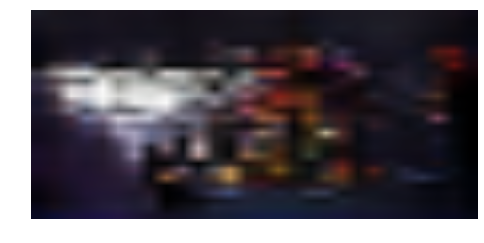

In [155]:
plot_samples_generated_by_model(loaded_dcgan, r=1, c=1)